# Data Challenge

## Course: Kernel Methods for Machine Learning
### M2-MVA (ENS-Paris Saclay)

Authors: Carlos Cuevas Villarmin and Javier Alejandro Lopetegui Gonzalez

**0. Import libraries**

In [2]:
import pickle as pkl
from scipy import optimize
from scipy.linalg import cho_factor, cho_solve

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

**1. Load training data.** Data is divided into three files. On the one hand the training data is provided in *Xtr.csv* and its corresponding labels in *Ytr.csv*. On the other hand, test data is in *Xte.csv* but it will be loaded once the model is trained.

The information about the structure of the data provided by the authors of the challenge is the following:

- Xtr.csv contains a matrix of size 5000 x 3072. One row represents a color image of size 32 x 32 pixels. The first 1024 values represent pixel intensities on the red channel, then the next 1024 represent the green channel, and the last 1024 entries, the blue channel. To make sure that you are reading the data correctly, you need to find a way to visualize images. Note that images have been pre-processed, and do not appear as a natural image.

- Ytr.csv contains a vector of labels corresponding to the training data, in the same format as a submission file. 

- Xte.csv contains 2000 test images. These are the ones you need to classify. The first row corresponds to image Id=1, then the last row corresponds to image Id=2000.

Taking it into account the first step is to load the data.

In [4]:
#Read training data
data_path = 'data/'
X_train = pd.read_csv(data_path+'Xtr.csv', sep=',', header=None)
Y_train = pd.read_csv(data_path+'Ytr.csv', sep=',')

In [5]:
import numpy as np 
import pandas as pd 

Xtr = np.array(pd.read_csv('data/Xtr.csv',header=None,sep=',',usecols=range(3072))) 
Xte = np.array(pd.read_csv('data/Xte.csv',header=None,sep=',',usecols=range(3072))) 
Ytr = np.array(pd.read_csv('data/Ytr.csv',sep=',',usecols=[1])).squeeze() 

# define your learning algorithm here 
# # for instance, define an object called ``classifier'' 
# # classifier.train(Ytr,Xtr) 
# # predict on the test data 
# # for instance, Yte = classifier.fit(Xte) 
# Yte = {'Prediction' : Yte} 
# dataframe = pd.DataFrame(Yte) dataframe.index += 1 
# dataframe.to_csv('Yte_pred.csv',index_label='Id') 

In [6]:
#Transform into pandas dataframe
X_train = pd.DataFrame(X_train)
Y_train = pd.DataFrame(Y_train)

#Visualize the data
display(X_train.head())
display(Y_train.head())

print(X_train.shape, Y_train.shape)


,0,1,2,3,4,5,6,7,8,9,...,3063,3064,3065,3066,3067,3068,3069,3070,3071,3072
0,0.007018,0.000323,0.002215,0.000781,-0.005636,-0.001525,-0.001090,-0.001907,0.004179,-0.004225,...,-0.002166,-0.005094,0.001906,-0.006143,-0.013265,-0.013873,0.005223,-0.000860,-0.012881,NaN
1,0.000819,0.001688,0.002698,0.004685,0.011166,0.017482,0.045989,0.031377,0.032150,0.062066,...,0.007203,0.008634,0.006800,0.014114,0.000243,-0.019384,-0.046763,-0.048919,-0.057449,NaN
2,-0.016779,0.006662,-0.007226,-0.003798,-0.004273,-0.009955,-0.030925,-0.007064,0.008136,0.000618,...,-0.023748,0.047707,0.072310,0.056837,0.045410,0.015561,0.003272,-0.013745,0.000968,NaN
3,0.014936,0.004218,0.009732,0.007309,0.004914,0.008172,0.014205,-0.023263,-0.023014,0.011482,...,-0.029634,-0.024069,-0.000788,-0.005010,-0.004260,0.014308,-0.010997,-0.025966,-0.025786,NaN
4,-0.073091,-0.046800,-0.056235,-0.063619,-0.088387,-0.044682,-0.014172,-0.077535,-0.100056,-0.066161,...,-0.018166,0.012983,0.022676,0.014233,0.047403,0.052239,-0.029272,0.001368,-0.001475,NaN


,Id,Prediction
0,1,8
1,2,9
2,3,3
3,4,1
4,5,4


(5000, 3073) (5000, 2)


Drop the last column of X_train because it is generated by the format of the data but it is unnecessary.

In [7]:
#Drop the last column of X_train
X_train = X_train.drop(columns=[3072])

In [8]:
display(X_train.head())

,0,1,2,3,4,5,6,7,8,9,...,3062,3063,3064,3065,3066,3067,3068,3069,3070,3071
0,0.007018,0.000323,0.002215,0.000781,-0.005636,-0.001525,-0.001090,-0.001907,0.004179,-0.004225,...,0.004146,-0.002166,-0.005094,0.001906,-0.006143,-0.013265,-0.013873,0.005223,-0.000860,-0.012881
1,0.000819,0.001688,0.002698,0.004685,0.011166,0.017482,0.045989,0.031377,0.032150,0.062066,...,-0.000530,0.007203,0.008634,0.006800,0.014114,0.000243,-0.019384,-0.046763,-0.048919,-0.057449
2,-0.016779,0.006662,-0.007226,-0.003798,-0.004273,-0.009955,-0.030925,-0.007064,0.008136,0.000618,...,-0.029953,-0.023748,0.047707,0.072310,0.056837,0.045410,0.015561,0.003272,-0.013745,0.000968
3,0.014936,0.004218,0.009732,0.007309,0.004914,0.008172,0.014205,-0.023263,-0.023014,0.011482,...,-0.004505,-0.029634,-0.024069,-0.000788,-0.005010,-0.004260,0.014308,-0.010997,-0.025966,-0.025786
4,-0.073091,-0.046800,-0.056235,-0.063619,-0.088387,-0.044682,-0.014172,-0.077535,-0.100056,-0.066161,...,0.011063,-0.018166,0.012983,0.022676,0.014233,0.047403,0.052239,-0.029272,0.001368,-0.001475


In [9]:
#Change the index from 0 to 4999 to 1 to 5000
X_train.index = X_train.index+1 #To have the same index as Y_train
display(X_train.head())

,0,1,2,3,4,5,6,7,8,9,...,3062,3063,3064,3065,3066,3067,3068,3069,3070,3071
1,0.007018,0.000323,0.002215,0.000781,-0.005636,-0.001525,-0.001090,-0.001907,0.004179,-0.004225,...,0.004146,-0.002166,-0.005094,0.001906,-0.006143,-0.013265,-0.013873,0.005223,-0.000860,-0.012881
2,0.000819,0.001688,0.002698,0.004685,0.011166,0.017482,0.045989,0.031377,0.032150,0.062066,...,-0.000530,0.007203,0.008634,0.006800,0.014114,0.000243,-0.019384,-0.046763,-0.048919,-0.057449
3,-0.016779,0.006662,-0.007226,-0.003798,-0.004273,-0.009955,-0.030925,-0.007064,0.008136,0.000618,...,-0.029953,-0.023748,0.047707,0.072310,0.056837,0.045410,0.015561,0.003272,-0.013745,0.000968
4,0.014936,0.004218,0.009732,0.007309,0.004914,0.008172,0.014205,-0.023263,-0.023014,0.011482,...,-0.004505,-0.029634,-0.024069,-0.000788,-0.005010,-0.004260,0.014308,-0.010997,-0.025966,-0.025786
5,-0.073091,-0.046800,-0.056235,-0.063619,-0.088387,-0.044682,-0.014172,-0.077535,-0.100056,-0.066161,...,0.011063,-0.018166,0.012983,0.022676,0.014233,0.047403,0.052239,-0.029272,0.001368,-0.001475


In [10]:
#Set the index of Y_train by the column Id
Y_train = Y_train.set_index('Id')
display(Y_train.head())

,Prediction
Id,
1,8
2,9
3,3
4,1
5,4


**2. Data visualization.** In order to have deeper knowledge of the data we are working with let visualize the images of the set.

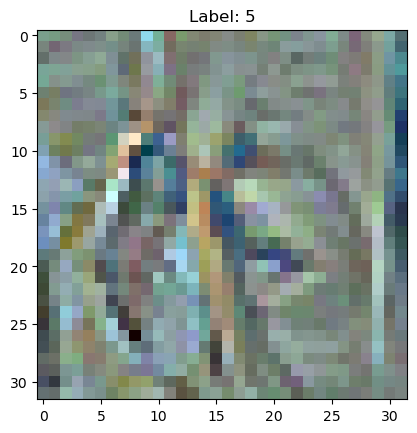

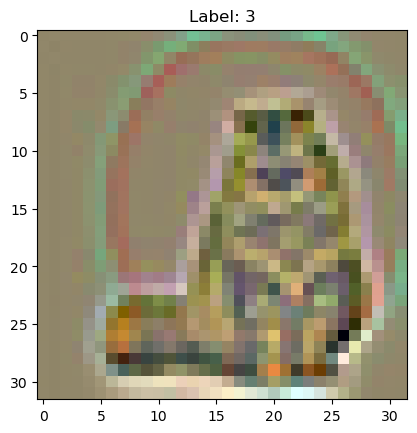

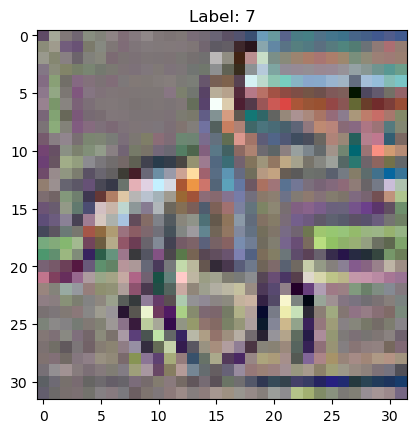

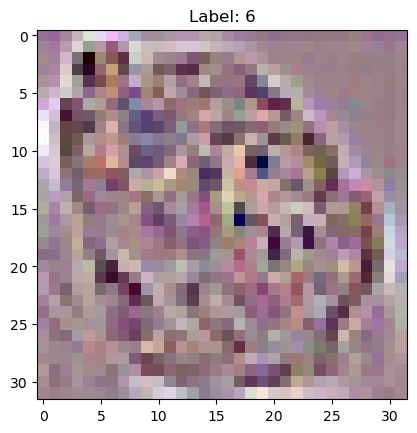

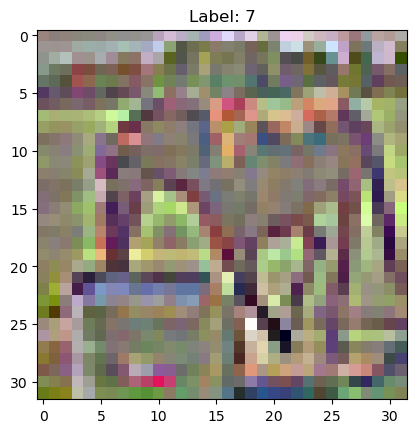

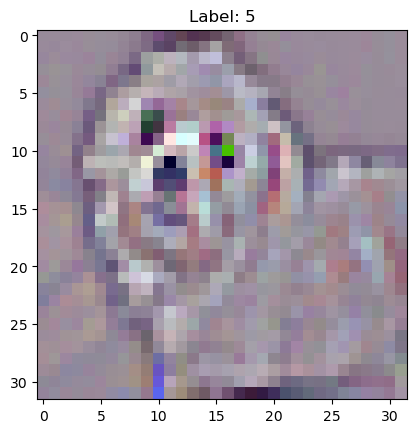

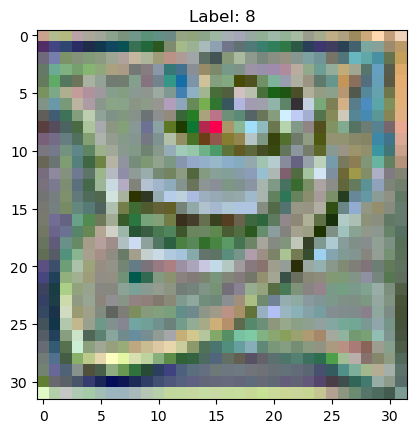

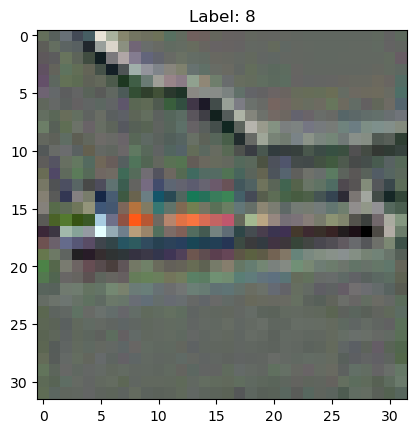

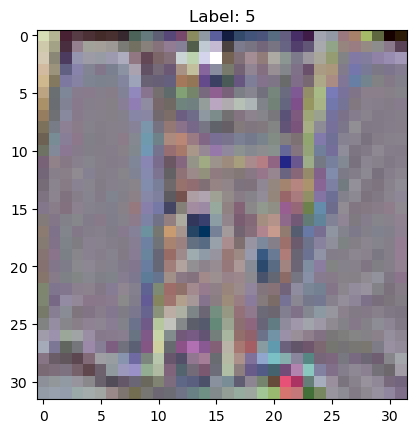

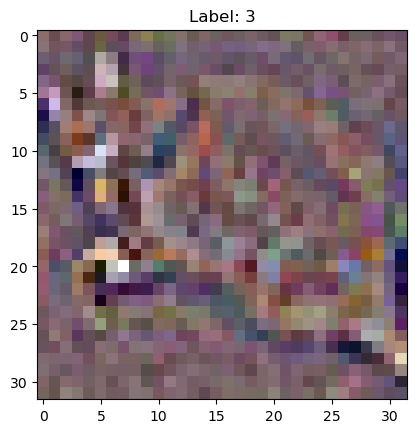

In [11]:
#Visualize the images of the first 5 samples
for i in range(10,20):
    # image = np.reshape(np.array(X_train.loc[i]), (3,32,32)).astype(float)
    image = np.reshape(Xtr[i], (3,32,32)).astype(float)


    #image = image / 2 + 0.5
    # Separate color channels
    red_channel = image[0]
    green_channel = image[1]
    blue_channel = image[2]

    
    # Normalize each channel 
    red_channel = (red_channel- red_channel.min()) / (red_channel.max()-red_channel.min())
    green_channel = (green_channel - green_channel.min()) / (green_channel.max()-green_channel.min())
    blue_channel = (blue_channel - blue_channel.min()) / (blue_channel.max() - blue_channel.min())

    # Combine channels to form the original image
    original_image = np.stack((red_channel, green_channel, blue_channel), axis=-1)

    plt.imshow(np.clip(original_image, a_min=0, a_max=1),cmap='viridis', vmin=0, vmax=1)
    plt.title('Label: '+str(Ytr[i]))
    plt.show()

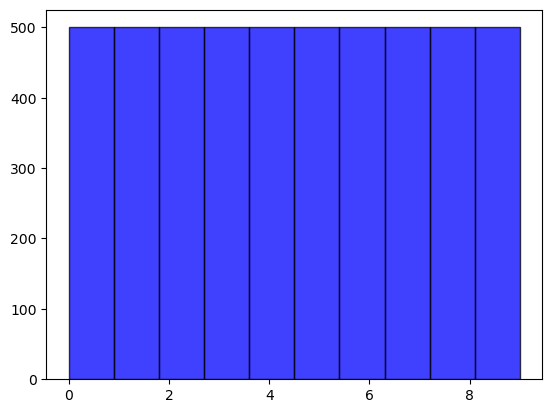

In [12]:
#Visualize the distribution of the labels
plt.hist(Ytr, bins=10, alpha=0.75, color='blue', edgecolor='black')
plt.show()

**Implementation of Kernel SVM**

In [13]:
class LinearKernel:
    def __call__(self, X1, X2):
        return X1 @ X2.T
class PolynomialKernel:
    def __init__(self, p=3):
        self.p = p
    def __call__(self, X1, X2):
        return (X1 @ X2.T + 1) ** self.p

class RBF:
    def __init__(self, sigma=1.):
        self.sigma = sigma  ## the variance of the kernel
    def __call__(self,X,Y):
        ## Input vectors X and Y of shape Nxd and Mxd
        dists = np.square(X)[:, np.newaxis].sum(axis=2) - 2*X @ Y.T + np.square(Y).sum(axis=1)
        return np.exp(-dists/(2*self.sigma**2))

In [14]:
class KernelSVC:
    
    def __init__(self, C, kernel, epsilon = 1e-3):
        self.type = 'non-linear'
        self.C = C                               
        self.kernel = kernel        
        self.alpha = None
        self.support = None
        self.epsilon = epsilon
        self.norm_f = None
       
    
    def fit(self, X, y):
       #### You might define here any variable needed for the rest of the code
        N = len(y)
        print("Building K...")
        K = self.kernel(X,X)
        print("Building K - done")
        # Lagrange dual problem
        def loss(alpha):
             #'''--------------dual loss ------------------ '''
            return -alpha@np.ones(N) + 0.5 * (alpha*y) @ K @ (alpha*y)

        # Partial derivate of Ld on alpha
        def grad_loss(alpha):
            # '''----------------partial derivative of the dual loss wrt alpha -----------------'''
            return np.diag(y) @ K @ (alpha*y) - np.ones(N)


        # Constraints on alpha of the shape :
        # -  d - C*alpha  = 0
        # -  b - A*alpha >= 0

        fun_eq = lambda alpha: alpha @ y # '''----------------function defining the equality constraint------------------'''        
        jac_eq = lambda alpha:  y  #'''----------------jacobian wrt alpha of the  equality constraint------------------'''
        fun_ineq = lambda alpha: np.hstack((np.zeros(N), self.C*np.ones(N))) + np.hstack((alpha, -alpha))  # '''---------------function defining the inequality constraint-------------------'''     
        jac_ineq = lambda alpha: np.vstack((np.eye(N), -1*np.eye(N))) # '''---------------jacobian wrt alpha of the  inequality constraint-------------------'''
        
        constraints = ({'type': 'eq',  'fun': fun_eq, 'jac': jac_eq},
                       {'type': 'ineq', 
                        'fun': fun_ineq , 
                        'jac': jac_ineq})

        optRes = optimize.minimize(fun=lambda alpha: loss(alpha),
                                   x0=np.ones(N), 
                                   method='SLSQP', 
                                   jac=lambda alpha: grad_loss(alpha), 
                                   constraints=constraints)
        self.alpha = optRes.x
        
        ## Assign the required attributes
        support_idxs  = np.argwhere(~np.isclose(self.alpha, 0)).squeeze()
        self.support = X[support_idxs]
        self.alpha_support = self.alpha[support_idxs]
        self.y_support = y[support_idxs]
        margin_idxs = np.intersect1d(support_idxs, np.argwhere(~np.isclose(self.alpha, self.C)).squeeze())
        self.margin_points = X[margin_idxs]#'''------------------- A matrix with each row corresponding to a point that falls on the margin ------------------'''
        
        self.b = np.mean(y[margin_idxs] - K[np.ix_(margin_idxs , support_idxs)] @ \
            (self.alpha_support*self.y_support))  #''' -----------------offset of the classifier------------------ '''
        self.norm_f = np.sqrt((self.alpha_support*self.y_support) @ \
            K[np.ix_(support_idxs , support_idxs)] @ (self.alpha_support*self.y_support))# '''------------------------RKHS norm of the function f ------------------------------'''


    ### Implementation of the separting function $f$ 
    def separating_function(self,x):
        # Input : matrix x of shape N data points times d dimension
        # Output: vector of size N
        return self.kernel(x, self.support) @ (self.alpha_support*self.y_support)

    
    
    def predict(self, X):
        """ Predict y values in {-1, 1} """
        d = self.separating_function(X)
        return 2 * (d+self.b> 0) - 1

In [53]:
class MulticlassKernelSVC:
    def __init__(self, C, kernel, epsilon = 1e-3):
        self.C = C
        self.kernel = kernel
        self.epsilon = epsilon
        self.models = []
        self.classes = []
    
    def fit(self, X, y):
        self.classes = np.unique(y)

        for c in self.classes:
            y_bin = 2*(y == c)-1
            y_c_idxs = np.where(y_bin == 1)[0]
            num_c = len(y_c_idxs)
            y_nc_idxs = np.where(y_bin == -1)[0]
            # get the same number of samples for each class
            y_nc = np.random.choice(y_nc_idxs, num_c, replace=False)
            y_bin = y_bin[np.union1d(y_c_idxs, y_nc)]
            X_bin = X[np.union1d(y_c_idxs, y_nc)]
            model = KernelSVC(self.C, self.kernel, self.epsilon)
            model.fit(X_bin, y_bin)
            # model.fit(X, y_bin)
            self.models.append(model)
    
    def predict(self, X):
        pred = np.zeros((X.shape[0], len(self.classes)))
        for i, model in enumerate(self.models):
            pred[:, i] = model.separating_function(X) + model.b
        return self.classes[np.argmax(pred, axis=1)]

In [34]:
# split the data into training and validation sets
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(Xtr, Ytr, test_size=0.2, random_state=42)

(array([ 95., 103.,  97.,  86., 100., 106., 120.,  96., 100.,  97.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

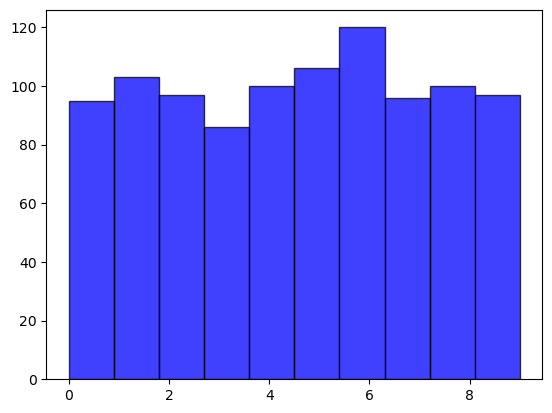

In [19]:
plt.hist(Y_val, bins=10, alpha=0.75, color='blue', edgecolor='black')

In [20]:
len(X_train), len(X_val), len(Y_train), len(Y_val)

(4000, 1000, 4000, 1000)

In [43]:
kernel = RBF(sigma=1)

In [44]:
multiKSVC = MulticlassKernelSVC(C=1, kernel=kernel)

In [45]:
multiKSVC.fit(X_train, Y_train)

Building K...
Building K - done
Building K...
Building K - done
Building K...
Building K - done
Building K...
Building K - done
Building K...
Building K - done
Building K...
Building K - done
Building K...
Building K - done
Building K...
Building K - done
Building K...
Building K - done
Building K...
Building K - done


In [46]:
y_pred = multiKSVC.predict(X_val)

In [47]:
sum(y_pred == Y_val) / len(Y_val)

0.222

In [41]:
Yte = multiKSVC.predict(Xte) 
Yte = {'Prediction' : Yte} 
dataframe = pd.DataFrame(Yte) 
dataframe.index += 1 
dataframe.to_csv('./Yte_pred.csv',index_label='Id')

In [29]:
# trying polynomial kernel
kernel = LinearKernel()

In [30]:
multiKSVC_poly = MulticlassKernelSVC(C=1, kernel=kernel)

In [31]:
multiKSVC_poly.fit(X_train, Y_train)

Building K...
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Building K - done
Building K...
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Building K - done
Building K...
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Building K - done
Building K...
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel on

In [32]:
y_pred_poly = multiKSVC_poly.predict(X_val)

In [33]:
sum(y_pred_poly == Y_val) / len(Y_val)

0.142

In [137]:
min(y_pred), max(y_pred)

(0, 9)

(array([161., 333., 233., 126., 179., 149., 114., 179., 153., 373.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

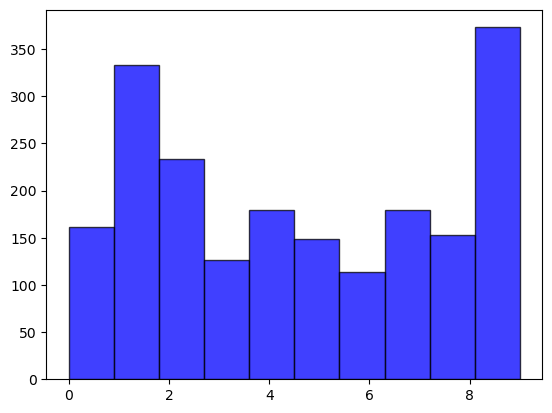

In [138]:
plt.hist(y_pred, bins=10, alpha=0.75, color='blue', edgecolor='black')

In [41]:
# Primero probando con las dos primeras etiquetas a ver q tal
indices= np.union1d(np.where(Ytr == 1)[0], np.where(Ytr == 2)[0])
len(indices)

1000

In [42]:
Y = Ytr[indices]
X = Xtr[indices]

In [44]:
# split X and Y into training and testing sets
from sklearn.model_selection import train_test_split
X_tr, X_t, Y_tr, Y_t = train_test_split(X, Y, test_size=0.2, random_state=42)
len(X_tr), len(X_t), len(Y_tr), len(Y_t)

(800, 200, 800, 200)

In [50]:
# Split the data into training and validation set
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(Xtr, Ytr, test_size=0.2, random_state=42)
print(X_train.shape, X_val.shape, Y_train.shape, Y_val.shape)

(4000, 3072) (1000, 3072) (4000,) (1000,)


In [97]:
kernel = RBF(sigma=5)

In [98]:
# train a linear SVM
classifier = KernelSVC(C=5, kernel=kernel)
classifier.fit(X_tr,np.array([1 if y == 1 else -1 for y in Y_tr]))

Building K...
Building K - done


In [48]:
# get the mean among the three channels
Xtr = Xtr.reshape(-1, 3, 32, 32).mean(axis=1).reshape(-1, 1024)
Xte = Xte.reshape(-1, 3, 32, 32).mean(axis=1).reshape(-1, 1024)

In [49]:
# split the data
X_train, X_val, Y_train, Y_val = train_test_split(Xtr, Ytr, test_size=0.2, random_state=42)

In [50]:
kernel = RBF(sigma=1)

In [54]:
multiKSVC_1 = MulticlassKernelSVC(C=1, kernel=kernel)

In [55]:
multiKSVC_1.fit(X_train, Y_train)

Building K...
Building K - done
Building K...
Building K - done
Building K...
Building K - done
Building K...
Building K - done
Building K...
Building K - done
Building K...
Building K - done
Building K...
Building K - done
Building K...
Building K - done
Building K...
Building K - done
Building K...
Building K - done


In [56]:
y_pred_1 = multiKSVC_1.predict(X_val)

In [57]:
sum(y_pred_1 == Y_val) / len(Y_val)

0.173